# Modelo multimodal CLIP

Modelos multimodais realizam o processamento de dados de múltiplas modalidades. Veremos especificamente sobre o processamento de texto e imagens, que são os chamados *visual language models*. 

Implementaremos o modelo CLIP, desenvolvido pela OpenAI.

Referências:

* [Learning Transferable Visual Models From Natural Language Supervision](https://arxiv.org/abs/2103.00020)
* [Repositório do Hugginface](https://github.com/huggingface/transformers/blob/main/src/transformers/models/clip/modeling_clip.py)


In [83]:
import torch
from dataset import collate_fn, get_dataset
from torch import nn
from torch.utils.data import DataLoader

ds, _ = get_dataset("../Graphs/data/images", "../Graphs/data/edgelists.json", split=0)
ds.transform = None
#dl = DataLoader(ds, batch_size=8, shuffle=False, collate_fn=collate_fn)
#imgs, texts = next(iter(dl))

In [40]:
ds.indices

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [41]:
len(ds)

2000

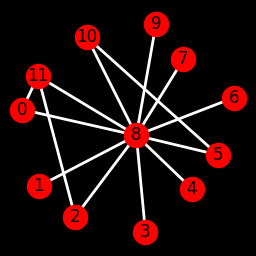

'0-8 0-11 1-8 2-8 2-11 3-8 4-8 5-8 5-10 6-8 7-8 8-9 8-10 8-11'

In [84]:
display(*ds[0])

### Extração de atributos de texto

In [43]:
from model import TextEncoder

text_encoder = TextEncoder()
features = text_encoder(texts)
features.shape


Device set to use cpu


torch.Size([8, 768])

### Extração de atributos de imagem

In [44]:
from torchvision.models import ResNet50_Weights, resnet50

image_encoder = resnet50(weights=ResNet50_Weights.DEFAULT)
image_encoder.fc = nn.Identity()
features = image_encoder(imgs)
features.shape

torch.Size([8, 2048])

### Modelo multimodal

Temos um codificador de imagens que extrai 2048 atributos para cada imagem de entrada e um codificador de texto que extrai 768 atributos para cada texto. Criaremos um modelo que calcula a similaridade entre esses atributos. 

In [45]:
class Clip(nn.Module):

    def __init__(self, image_encoder, text_encoder, img_dim, text_dim,
                 temp=2.6592, dim=512):
        super().__init__()

        self.image_encoder = image_encoder
        self.text_encoder = text_encoder
        # Camadas de projeção
        self.visual_projection = nn.Linear(img_dim, dim, bias=False)
        self.text_projection = nn.Linear(text_dim, dim, bias=False)
        # Parâmetro treinável responsável por reescalar os valores de similaridade
        self.logit_scale = nn.Parameter(torch.tensor(temp)) 

    def project_images(self, imgs):
        """Codifica imagens."""

        image_embeds = self.image_encoder(imgs)
        image_embeds = self.visual_projection(image_embeds)
        # Normaliza os valores pela magnitude do vetor, que é a raiz quadrada 
        # da soma dos valores ao quadrado
        image_embeds = image_embeds / image_embeds.norm(p=2, dim=-1, keepdim=True)

        return image_embeds
    
    def project_texts(self, texts):
        """Codifica textos."""

        text_embeds = self.text_encoder(texts)
        text_embeds = self.text_projection(text_embeds)
        text_embeds = text_embeds / text_embeds.norm(p=2, dim=-1, keepdim=True)

        return text_embeds

    def forward(self, imgs, texts, return_emb=False):

        image_embeds = self.project_images(imgs)
        text_embeds = self.project_texts(texts)
        
        logit_scale = self.logit_scale.exp()

        # Similaridade de coseno. Cada linha i dessa matriz representa a 
        # similaridade entre o texto i e as imagens do batch. O elemento
        # (i,i) representa a similaridade entre o texto i e a imagem correta 
        # que corresponde a esse texto, enquanto que os demais elementos da 
        # linha correspondem a correspondências incorretas. 
        # text_embeds: bs x dim
        # image_embeds.t(): dim x 
        # logits_per_text: bs x bs
        logits_per_text = torch.matmul(text_embeds, image_embeds.t()) * logit_scale

        output = logits_per_text
        # Opcionalmente, retorna as projeções das imagens e textos
        if return_emb:
            output += (image_embeds, text_embeds)

        return output
    
def contrastive_loss(logits_per_text):
    """Calcula a entropia cruzada para cada linha da matriz, considerando
    que a "classe" correta da linha i é dada pela coluna i."""

    scores = logits_per_text
    targets = torch.arange(len(logits_per_text), device=logits_per_text.device)
    loss = nn.functional.cross_entropy(scores, targets)

    return loss

def clip_loss(logits_per_text):
    """Queremos que a matriz de similaridade possua valores altos na diagonal,
    e valores baixos fora da diagonal. Essa loss também é chamada de InfoNCE."""

    caption_loss = contrastive_loss(logits_per_text)
    image_loss = contrastive_loss(logits_per_text.t())
    return (caption_loss + image_loss) / 2.0

# Se quisermos evitar de treinar o encoder de texto, podemos desabilitar
# os gradientes
text_encoder.requires_grad_(False)
model = Clip(image_encoder, text_encoder, img_dim=2048, text_dim=768)

logits_per_text = model(imgs, texts)
loss = clip_loss(logits_per_text)
loss

tensor(2.1244, grad_fn=<DivBackward0>)

In [46]:
from transformers import AutoTokenizer

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# exemplo: BERT
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# texts vem do DataLoader como lista de strings
enc_texts = tokenizer(list(texts), padding=True, truncation=True, return_tensors="pt")

# batch de tensores
text_batch = enc_texts["input_ids"].to(device)
attn_mask = enc_texts["attention_mask"].to(device)

In [47]:
enc_texts["input_ids"][0]

tensor([ 101, 1014, 1011, 1022, 1014, 1011, 2340, 1015, 1011, 1022, 1016, 1011,
        1022, 1016, 1011, 2340, 1017, 1011, 1022, 1018, 1011, 1022, 1019, 1011,
        1022, 1019, 1011, 2184, 1020, 1011, 1022, 1021, 1011, 1022, 1022, 1011,
        1023, 1022, 1011, 2184, 1022, 1011, 2340,  102])

In [48]:
tokenizer.decode(2184)

'10'

In [49]:
texts[0]

'0-8 0-11 1-8 2-8 2-11 3-8 4-8 5-8 5-10 6-8 7-8 8-9 8-10 8-11'

In [50]:
def similarity(model, image, enc_texts, device="cpu"):
    model.eval()
    with torch.no_grad():
        # imagem
        img_emb = model.project_images(image.to(device))
        
        # textos já tokenizados
        text_embs = model.project_texts(enc_texts)
        
        sim = torch.matmul(img_emb, text_embs.T).squeeze(0)
    return sim

In [51]:
images = imgs.to(device)
sims = similarity(model, images, list(texts), device)

print("Similaridades:", sims)

Similaridades: tensor([[-0.0143, -0.0129, -0.0128, -0.0151, -0.0123, -0.0159, -0.0136, -0.0139],
        [-0.0266, -0.0257, -0.0253, -0.0281, -0.0259, -0.0286, -0.0271, -0.0267],
        [-0.0095, -0.0081, -0.0077, -0.0109, -0.0083, -0.0113, -0.0080, -0.0098],
        [-0.0079, -0.0057, -0.0066, -0.0070, -0.0068, -0.0099, -0.0080, -0.0064],
        [ 0.0327,  0.0329,  0.0341,  0.0313,  0.0329,  0.0305,  0.0318,  0.0314],
        [-0.0306, -0.0286, -0.0293, -0.0311, -0.0291, -0.0313, -0.0291, -0.0299],
        [-0.0184, -0.0182, -0.0178, -0.0197, -0.0183, -0.0212, -0.0209, -0.0195],
        [ 0.0132,  0.0151,  0.0143,  0.0123,  0.0140,  0.0100,  0.0128,  0.0135]],
       device='cuda:0')


In [52]:
sims.shape

torch.Size([8, 8])

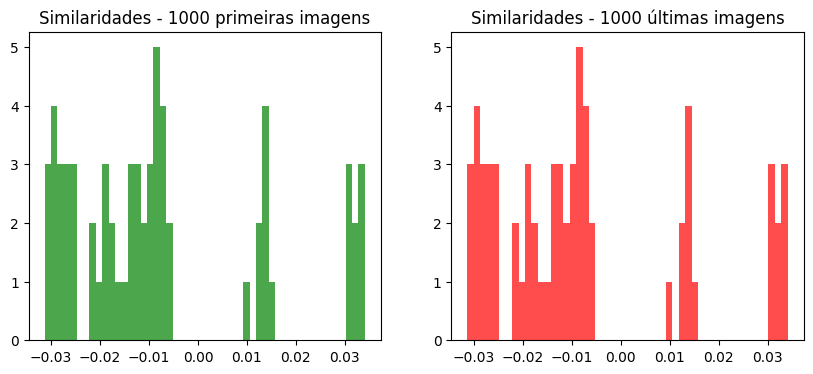

In [53]:
import matplotlib.pyplot as plt
import numpy

# primeiras 1000 imagens
sims_first1000 = sims[:1000].reshape(-1)   # pega linhas 0–999
# últimas 1000 imagens
sims_last1000 = sims[-1000:].reshape(-1)   # pega linhas finais

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.hist(sims_first1000.cpu().numpy(), bins=50, color="green", alpha=0.7)
plt.title("Similaridades - 1000 primeiras imagens")

plt.subplot(1,2,2)
plt.hist(sims_last1000.cpu().numpy(), bins=50, color="red", alpha=0.7)
plt.title("Similaridades - 1000 últimas imagens")

plt.show()

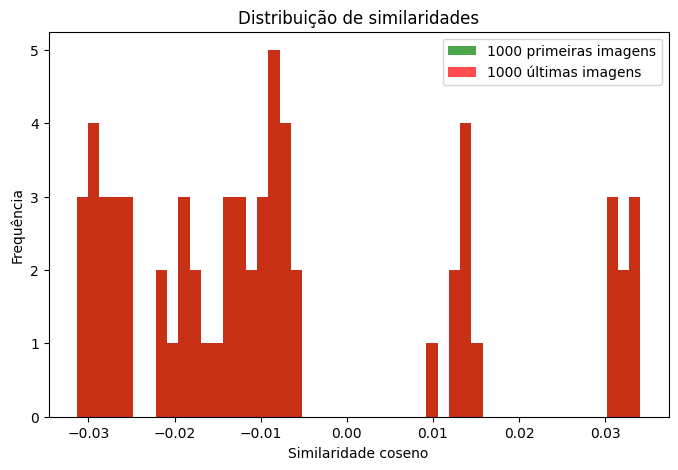

In [54]:
plt.figure(figsize=(8,5))

plt.hist(sims_first1000.cpu().numpy(), bins=50, alpha=0.7, color="green", label="1000 primeiras imagens")
plt.hist(sims_last1000.cpu().numpy(), bins=50, alpha=0.7, color="red", label="1000 últimas imagens")

plt.xlabel("Similaridade coseno")
plt.ylabel("Frequência")
plt.title("Distribuição de similaridades")
plt.legend()
plt.show()

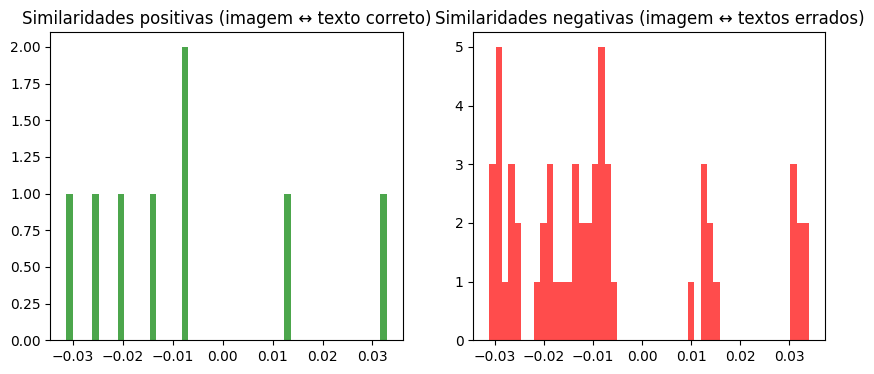

In [55]:
# pega a diagonal -> imagem i com texto i
positives = sims.diag().cpu().numpy()

# pega tudo fora da diagonal -> negativos
mask = ~torch.eye(sims.size(0), dtype=bool, device=sims.device)
negatives = sims[mask].cpu().numpy()

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.hist(positives, bins=50, color="green", alpha=0.7)
plt.title("Similaridades positivas (imagem ↔ texto correto)")

plt.subplot(1,2,2)
plt.hist(negatives, bins=50, color="red", alpha=0.7)
plt.title("Similaridades negativas (imagem ↔ textos errados)")

plt.show()


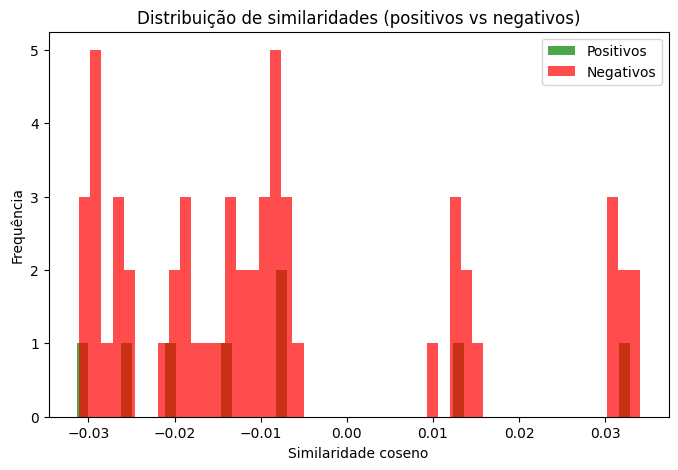

In [56]:
pos_sims = sims.diag()                          # diagonal -> imagem i com texto i
mask = ~torch.eye(sims.size(0), dtype=bool, device=sims.device)
neg_sims = sims[mask]                           # off-diagonal -> todos os pares incorretos

plt.figure(figsize=(8,5))

plt.hist(pos_sims.cpu().numpy(), bins=50, alpha=0.7, color="green", label="Positivos")
plt.hist(neg_sims.cpu().numpy(), bins=50, alpha=0.7, color="red", label="Negativos")

plt.xlabel("Similaridade coseno")
plt.ylabel("Frequência")
plt.title("Distribuição de similaridades (positivos vs negativos)")
plt.legend()
plt.show()


In [70]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="../data/checkpoints/clip-model",
    num_train_epochs=20,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=1,
    warmup_steps=50,
    learning_rate=1e-4,
    weight_decay=0.01,
    logging_steps=10,
    save_strategy="epoch",
    optim="adamw_torch_fused",
    bf16=True if torch.cuda.is_available() else False,
    report_to="none",
)


In [71]:
# Configurações
device = "cuda" if torch.cuda.is_available() else "cpu"

ds_train, ds_valid = get_dataset("../Graphs/data/images", "../Graphs/data/edgelists.json", split=0)
dl = torch.utils.data.DataLoader(ds_train, batch_size=training_args.per_device_train_batch_size, shuffle=True)

optimizer = torch.optim.AdamW(model.parameters(), lr=training_args.learning_rate, weight_decay=training_args.weight_decay)

model.to(device)
model.train()

for epoch in range(int(training_args.num_train_epochs)):
    total_loss = 0
    for step, (imgs, texts) in enumerate(dl):
        imgs = imgs.to(device)

        # Tokeniza os textos do batch
        enc_texts = tokenizer(
            list(texts), padding=True, truncation=True, return_tensors="pt"
        ).to(device)

        optimizer.zero_grad()

        # logits = (batch_img, batch_text) → matriz (B, B)
        logits = model(imgs, list(texts))

        # CLIP loss (InfoNCE)
        loss = clip_loss(logits)
        loss.backward()

        # grad accumulation
        if (step + 1) % training_args.gradient_accumulation_steps == 0:
            optimizer.step()

        total_loss += loss.item()

    # logging
    avg_loss = total_loss / len(dl)
    print(f"Epoch {epoch+1}/{training_args.num_train_epochs}, Loss média: {avg_loss:.4f}")


Epoch 1/20, Loss média: 1.2743
Epoch 2/20, Loss média: 1.1617
Epoch 3/20, Loss média: 1.0692
Epoch 4/20, Loss média: 1.0071
Epoch 5/20, Loss média: 0.9592
Epoch 6/20, Loss média: 0.9486
Epoch 7/20, Loss média: 0.8294
Epoch 8/20, Loss média: 0.8200
Epoch 9/20, Loss média: 0.7529
Epoch 10/20, Loss média: 0.7400
Epoch 11/20, Loss média: 0.7148
Epoch 12/20, Loss média: 0.6758
Epoch 13/20, Loss média: 0.6551
Epoch 14/20, Loss média: 0.6423
Epoch 15/20, Loss média: 0.6210
Epoch 16/20, Loss média: 0.6065
Epoch 17/20, Loss média: 0.6217
Epoch 18/20, Loss média: 0.5728
Epoch 19/20, Loss média: 0.5483
Epoch 20/20, Loss média: 0.5396


In [72]:
len(ds_train)

2000

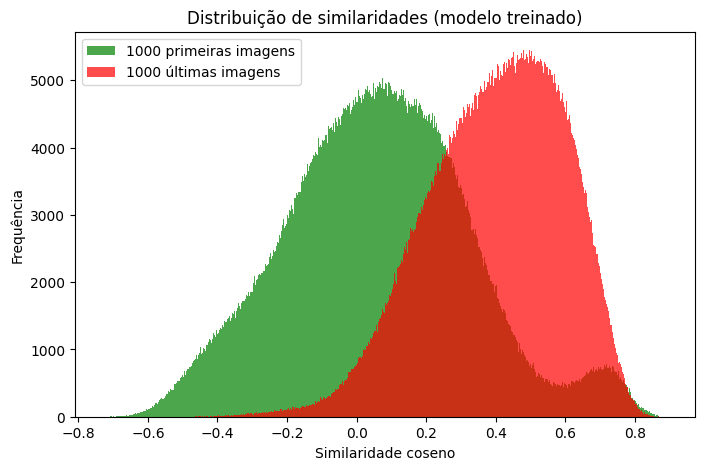

In [73]:
def compute_sims(model, ds, device="cpu"):
    model.eval()
    all_image_embs = []
    all_texts = []

    with torch.no_grad():
        for imgs, texts in ds:
            imgs = imgs.to(device).unsqueeze(0)
            all_image_embs.append(model.project_images(imgs))
            all_texts.append(texts)  # mantém lista de strings

        # concatena embeddings de todas as imagens
        image_embs = torch.cat(all_image_embs, dim=0)  # (num_images, dim)

        # codifica todos os textos
        text_embs = model.project_texts(all_texts).to(device)  # (num_texts, dim)

        # matriz de similaridade coseno
        sims = torch.matmul(image_embs, text_embs.T)  # (num_images, num_texts)

    return sims

# Calcula similaridades
sims = compute_sims(model, ds_train, device=device)

# Histograma comparando 1000 primeiras vs 1000 últimas imagens
sims_first1000 = sims[:1000].reshape(-1)
sims_last1000 = sims[-1000:].reshape(-1)

plt.figure(figsize=(8,5))
plt.hist(sims_first1000.cpu().numpy(), bins=1000, alpha=0.7, color="green", label="1000 primeiras imagens")
plt.hist(sims_last1000.cpu().numpy(), bins=1000, alpha=0.7, color="red", label="1000 últimas imagens")

plt.xlabel("Similaridade coseno")
plt.ylabel("Frequência")
plt.title("Distribuição de similaridades (modelo treinado)")
plt.legend()
plt.show()

In [74]:
sims.shape

torch.Size([2000, 2000])

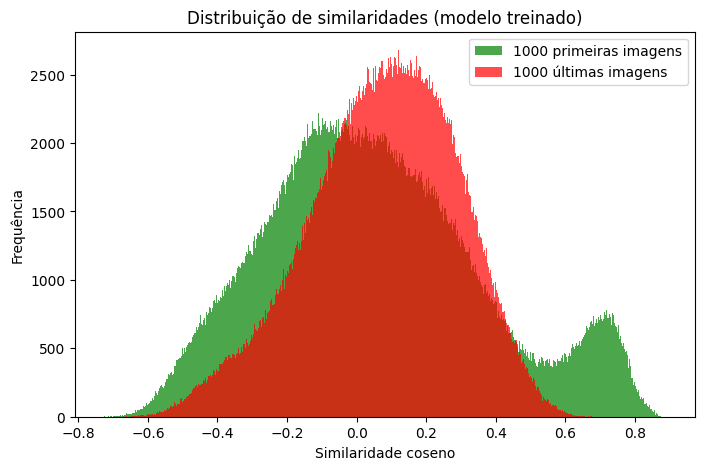

In [75]:
sims_first1000 = sims[:1000, :1000].reshape(-1)
sims_last1000 = sims[:1000, 1000:].reshape(-1)

plt.figure(figsize=(8,5))
plt.hist(sims_first1000.cpu().numpy(), bins=1000, alpha=0.7, color="green", label="1000 primeiras imagens")
plt.hist(sims_last1000.cpu().numpy(), bins=1000, alpha=0.7, color="red", label="1000 últimas imagens")

plt.xlabel("Similaridade coseno")
plt.ylabel("Frequência")
plt.title("Distribuição de similaridades (modelo treinado)")
plt.legend()
plt.show()

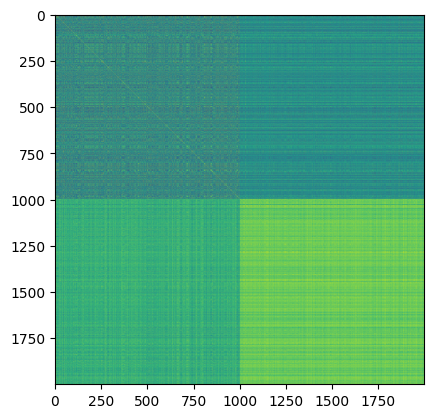

In [80]:
plt.imshow(sims.detach().cpu())

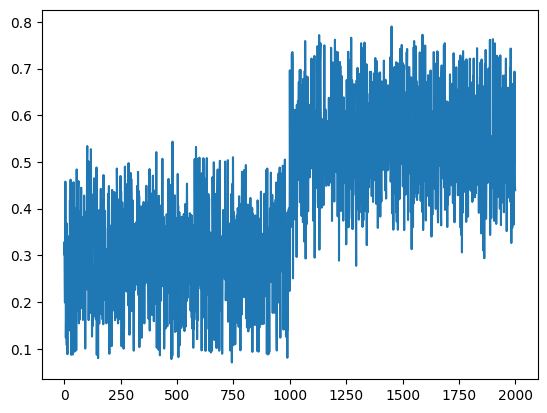

In [85]:
plt.plot(sims[-100].cpu())

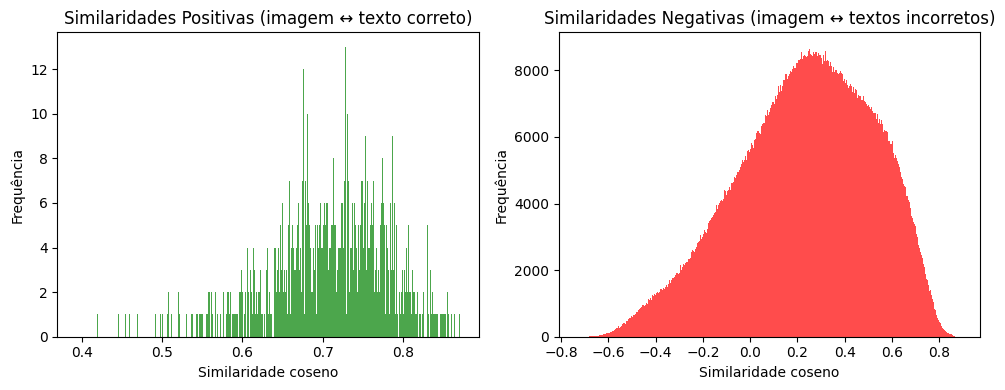

In [76]:
import matplotlib.pyplot as plt
import torch

# garantir diagonal segura
num = min(sims.size(0), sims.size(1))
pos_sims = sims[:num, :num].diagonal()
mask = ~torch.eye(num, dtype=bool, device=sims.device)
neg_sims = sims[:num, :num][mask]

plt.figure(figsize=(10,4))

# Histograma dos positivos
plt.subplot(1,2,1)
plt.hist(pos_sims.cpu().numpy(), bins=1000, color="green", alpha=0.7)
plt.title("Similaridades Positivas (imagem ↔ texto correto)")
plt.xlabel("Similaridade coseno")
plt.ylabel("Frequência")

# Histograma dos negativos
plt.subplot(1,2,2)
plt.hist(neg_sims.cpu().numpy(), bins=1000, color="red", alpha=0.7)
plt.title("Similaridades Negativas (imagem ↔ textos incorretos)")
plt.xlabel("Similaridade coseno")
plt.ylabel("Frequência")

plt.tight_layout()
plt.show()


### Zero-shot classification

Como o modelo envolve similaridade entre texto e imagens, é difícil medir a qualidade de forma intuitiva. Uma forma de fazer isso é verificando a capacidade do modelo de ser aplicado em outras tarefas como classificação de imagens. Como o modelo não foi treinado para tal tarefa, isso é chamado de zero-shot accuracy.

Vamos implementar uma função simples de acurácia que verifica a capacidade do modelo em classificar as imagens nas classes gato e chachorro.

In [77]:
@torch.no_grad()
def zero_shot_classification(model, imgs, label_embeds):

    # Projeção das imagens
    image_embeds = model.project_images(imgs)
    # Similaridade entre cada imagem e as palavras 'cat' e 'dog'
    scores = torch.matmul(image_embeds, label_embeds.t())
    # Índice da classe mais provável
    predictions = scores.argmax(dim=1)

    return predictions

label_embeds = model.project_texts(["cat", "dog"])
predictions = zero_shot_classification(model, imgs, label_embeds)
print(predictions)

tensor([0, 1, 1, 0, 0, 1, 1, 0], device='cuda:0')


In [78]:
def accuracy(predictions, texts):
    """Mede a acurácia do modelo. Esta função estima a classe correta de cada imagem utilizando
    as respectivas legendas. O ideal seria utilizar as classes conhecidas do dataset Oxford Pets,
    mas isso adicionaria complexidade ao código."""
    
    targets = []
    for text in texts:
        if "cat" in text or "kitten" in text:
            target = 0
        elif "dog" in text or "puppy" in text:
            target = 1
        else:
            # Classe não reconhecida
            target = 2
        targets.append(target)
    targets = torch.tensor(targets, device=predictions.device)

    # Fração das imagens da classe gato (cachorro) que são mais similares à 
    # palavra 'cat' ('dog')
    mask = targets!=2
    targets = targets[mask]
    predictions = predictions[mask]
    acc = (predictions==targets).float().mean()

    return acc

accuracy(predictions, texts)

tensor(nan, device='cuda:0')